In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Anomaly Detection on Batch and Streaming Data using Apache Beam (Z-Score Method)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/anomaly_detection/anomaly_detection_zscore.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/anomaly_detection/anomaly_detection_zscore.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This notebook demonstrates how to perform anomaly detection on both batch and streaming data using the `AnomalyDetection` PTransform:

1. **Batch Anomaly Detection**: This section focuses on processing a static dataset. A synthetic univariate dataset containing outliers is generated. Subsequently, the AnomalyDetection PTransform, utilizing the Z-Score algorithm, is applied to identify and log the outliers.

2. **Streaming Anomaly Detection with Concept Drift**: This section simulates a real-time environment where the data distribution changes over time. A synthetic dataset incorporating both outliers and concept drift is published to a Pub/Sub topic. An Apache Beam pipeline is configured to:

    * Read the streaming data from the input Pub/Sub topic.
    * Apply the AnomalyDetection PTransform within a sliding window.
    * Publish the enriched results (original data, anomaly scores, and labels) to an output Pub/Sub topic.
  
    Finally, the labeled data points are visulaized in a series of plots to observe the detection performance in a streaming context with concept drift.



## Preparation
To get started with this notebook, you'll need to install the Apache Beam Python SDK and its associated extras. Make sure your installation is version 2.64.0 or later.

In [ ]:
! pip install 'apache_beam[interactive,gcp]>=2.64.0' --quiet

To proceed, import the essential modules: matplotlib, numpy, pandas, Beam, and others as needed.

In [2]:
# Import required dependencies for the notebook
import json
import os
import random
import threading
import time
import warnings
from typing import Any
from typing import Iterable
from typing import Tuple

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, Javascript
from google.api_core import retry
from google.api_core.exceptions import AlreadyExists
from google.cloud import pubsub_v1
from google.cloud.exceptions import NotFound

import apache_beam as beam
from apache_beam.io.gcp.pubsub import PubsubMessage
from apache_beam.ml.anomaly.base import AnomalyResult
from apache_beam.ml.anomaly.base import AnomalyPrediction
from apache_beam.ml.anomaly.detectors.zscore import ZScore
from apache_beam.ml.anomaly.transforms import AnomalyDetection
from apache_beam.ml.anomaly.univariate.mean import IncLandmarkMeanTracker
from apache_beam.ml.anomaly.univariate.stdev import IncLandmarkStdevTracker
from apache_beam.ml.anomaly.univariate.mean import IncSlidingMeanTracker
from apache_beam.ml.anomaly.univariate.stdev import IncSlidingStdevTracker
from apache_beam.options.pipeline_options import PipelineOptions

# Suppress logging warnings
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"
warnings.filterwarnings('ignore')

 Next, replace `<PROJECT_ID>` with your Google Cloud project ID.

In [3]:
# GCP-related constant are listed below

# GCP project id
PROJECT_ID = 'apache-beam-testing'  # @param {type:'string'}

SUFFIX = str(random.randint(0, 10000))

# Pubsub topic and subscription for retrieving input data
INPUT_TOPIC = 'anomaly-input-' + SUFFIX
INPUT_SUB = INPUT_TOPIC + '-sub'

# Pubsub topic and subscription for collecting output result
OUTPUT_TOPIC = 'anomaly-output-' + SUFFIX
OUTPUT_SUB = OUTPUT_TOPIC + '-sub'

The last preparation step needs to authenticate your Google account and authorize your Colab notebook to access Google Cloud Platform (GCP) resources associated with the project set above.

In [4]:
from google.colab import auth
auth.authenticate_user(project_id=PROJECT_ID)

## Part 1: Batch Processing

### Generating Synthetic Data with Outliers
This process synthesizes a dataset (N=200) for anomaly detection. The generation consists of two key steps:

- A base dataset is generated from a standard normal distribution (μ=0,σ=1).
- Global outliers are introduced by replacing 1% of these points with values drawn from a normal distribution with a significant mean shift (μ=9,σ=1).

A fixed random seed is used to ensure reproducibility.

In [5]:
# The size of a segment in the synthetic data set.
seg_size = 200

# The ratio of global outliers introduced in the synthetic data set.
outlier_ratio = 0.01

# Random seed
seed = 1234

np.random.seed(seed)

# starting from a fixed distribution
data = np.random.normal(loc=0, scale=1, size=seg_size)

# adding outliers
outlier_idx = np.random.choice(len(data), size=int(outlier_ratio * len(data)), replace = False)

for idx in outlier_idx:
    data[idx] = np.random.normal(loc=9, scale=1, size=1).item()

df = pd.Series(data, name='f1')

Run the following code to visualize the dataset on a scatter plot.

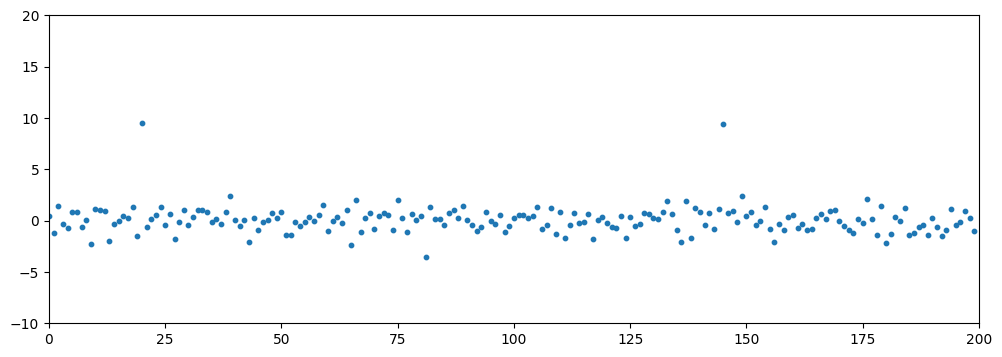

In [6]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.scatter(x=range(len(df)), y=df, s=10)

### Run the Beam Pipeline on the Batch Data

The following Beam pipeline implements an anomaly detection workflow on batch data. It executes the following steps in sequence:

- **Ingest and Format**: The pipeline begins by ingesting a collection of numerical data and converting each number into a `beam.Row`.

- **Key for Stateful Processing**: A single global key is assigned to every element. This ensures all data is processed by a single instance of the downstream stateful transform.

- **Anomaly Detection**: The `AnomalyDetection` PTransform is applied to the keyed data.

- **Log Outliers**: A `Filter` transform inspects the prediction output from the detector, retaining only the elements flagged as anomalies (label == 1). These outlier records are then logged for inspection or downstream action.

In [7]:
options = PipelineOptions()
with beam.Pipeline(options=options) as p:
    _ = (p | beam.Create(data)
        | "Convert to Rows" >> beam.Map(lambda x: beam.Row(f1=float(x))).with_output_types(beam.Row)
        | beam.WithKeys(0)
        | AnomalyDetection(ZScore(features=["f1"],
                                  sub_stat_tracker=IncLandmarkMeanTracker(100),
                                  stdev_tracker=IncLandmarkStdevTracker(100)))
        | beam.Filter(lambda x: x[1].predictions[0].label == 1)
        | beam.LogElements()
    )

(0, AnomalyResult(example=Row(f1=9.544331108822645), predictions=[AnomalyPrediction(model_id='ZScore', score=8.672319197619325, label=1, threshold=3, info='', source_predictions=None)]))
(0, AnomalyResult(example=Row(f1=9.388712735779308), predictions=[AnomalyPrediction(model_id='ZScore', score=7.32926235264911, label=1, threshold=3, info='', source_predictions=None)]))


## Part 2: Streaming Processing

### Generating Synthetic Data with Concept Drift
This data generation process synthesizes a single data set (N=1000) composed of five distinct segments, each designed to simulate a specific distributional behavior or type of concept drift. After concatenating these segments, global outliers with a larger mean are injected to complete the dataset.

In [8]:
# The size of a segment in the synthetic data set. Each segment represents
# a collection of data points generated from either a fixed distribution
# or a drift from one distribution to another.
# The idea is inspired by https://github.com/yixiaoma666/SCAR.
seg_size = 200

# The ratio of global outliers introduced in the synthetic data set.
outlier_ratio = 0.01

# Random seed
seed = 1234

np.random.seed(seed)

# Starting from a fixed distribution
data_seg1 = np.random.normal(loc=0, scale=1, size=seg_size)

# A sudden change between data_seg1 and data_seg2
data_seg2 = np.random.normal(loc=3, scale=3, size=seg_size)

# A gradual change in data_seg3
data_seg3 = []
for i in range(seg_size):
    prob = 1 - 1.0 * i / seg_size
    c = np.random.choice(2, 1, p = [prob, 1 - prob])
    if c == 0:
        data_seg3.append(np.random.normal(loc=3, scale=3, size=1))
    else:
        data_seg3.append(np.random.normal(loc=0, scale=1, size=1))
data_seg3 = np.array(data_seg3).ravel()

# An incremental change in data_seg4
data_seg4 = []
for i in range(seg_size):
    loc = 0 + 3.0 * i / seg_size
    scale = 1 + 2.0 * i / seg_size
    data_seg4.append(np.random.normal(loc=loc, scale=scale, size=1))
data_seg4 = np.array(data_seg4).ravel()

# Back to a fixed distribution
data_seg5 = np.random.normal(loc=3, scale=3, size=seg_size)

# Combining all segements
data = np.concatenate((data_seg1, data_seg2, data_seg3, data_seg4, data_seg5))

# Adding global outliers
outlier_idx = np.random.choice(len(data), size=int(outlier_ratio * len(data)), replace = False)

for idx in outlier_idx:
    data[idx] = np.random.normal(loc=15, scale=1, size=1).item()

df = pd.Series(data, name='f1')

Run the following code to visualize the dataset on a scatter plot.

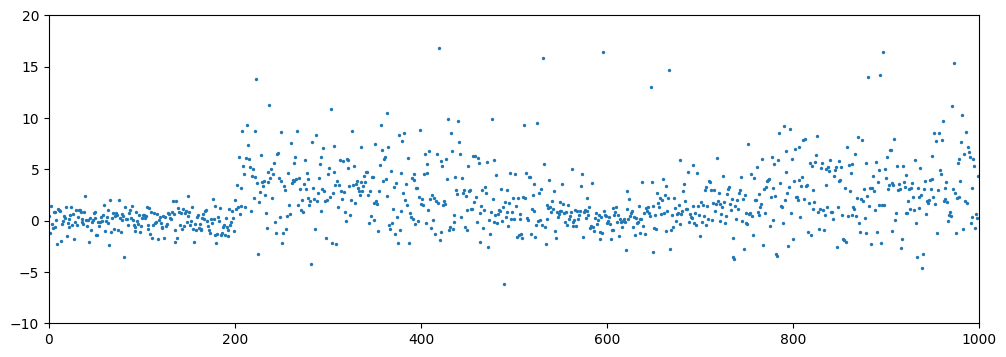

In [9]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 1000)
plt.ylim(-10, 20)
plt.scatter(x=range(len(df)), y=df, s=2)

### Setting Up Input/Output Pubsubs
Use the following code to create pubsub topics for input and output.

In [10]:
def create_topic_if_not_exists(project_id:str, topic_name:str, enable_message_ordering=False):
    if enable_message_ordering:
        # see https://cloud.google.com/pubsub/docs/ordering#python for details.
        publisher_options = pubsub_v1.types.PublisherOptions(enable_message_ordering=True)
        # Sending messages to the same region ensures they are received in order
        client_options = {"api_endpoint": "us-east1-pubsub.googleapis.com:443"}
        publisher = pubsub_v1.PublisherClient(publisher_options=publisher_options, client_options=client_options)
    else:
        publisher = pubsub_v1.PublisherClient()

    topic_path = publisher.topic_path(project_id, topic_name)
    try:
        topic = publisher.create_topic(request={"name": topic_path})
        print(f"Created topic: {topic.name}")
    except AlreadyExists:
        print(f"Topic {topic_path} already exists.")

    return publisher

def create_subscription_if_not_exists(project_id:str, subscription_name:str, topic_name: str, enable_message_ordering=False):
    topic_path = pubsub_v1.PublisherClient.topic_path(project_id, topic_name)
    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_name)
    try:
        subscription = subscriber.create_subscription(
            request={"name": subscription_path, "topic": topic_path, "enable_message_ordering": enable_message_ordering}
        )
        print(f"Created subscription: {subscription.name}")
    except AlreadyExists:
        print(f"Subscription {subscription_path} already exists.")

    return subscriber

In [11]:
# for input data
input_publisher = create_topic_if_not_exists(PROJECT_ID, INPUT_TOPIC, True)
create_subscription_if_not_exists(PROJECT_ID, INPUT_SUB, INPUT_TOPIC, True)

# for output data
create_topic_if_not_exists(PROJECT_ID, OUTPUT_TOPIC)
output_subscriber = create_subscription_if_not_exists(PROJECT_ID, OUTPUT_SUB, OUTPUT_TOPIC)

Created topic: projects/apache-beam-testing/topics/anomaly-input-9625
Created subscription: projects/apache-beam-testing/subscriptions/anomaly-input-9625-sub
Created topic: projects/apache-beam-testing/topics/anomaly-output-9625
Created subscription: projects/apache-beam-testing/subscriptions/anomaly-output-9625-sub


### Publishing Input to Pub/Sub
To simulate a live data stream without blocking the execution, the following code starts a separate thread to publish the generated data to the input Pub/Sub topic.

In [12]:
def publish_data(publisher, project_id: str, topic: str, data: Iterable[Any], delay=0.01, enable_message_ordering=False) -> None:
    topic_path = publisher.topic_path(project_id, topic)
    for i in range(len(data)):
        kv = {"f1": data.iloc[i]}
        kv["id"] = i  # add event id
        msg = json.dumps(kv).encode('utf-8')
        if enable_message_ordering:
            # set ordering key to a fixed string so messages with the same ordering key will be published in order
            publisher.publish(topic_path, data=msg, ordering_key="my-order-key")
        else:
            publisher.publish(topic_path, data=msg)
        time.sleep(delay)

publisher_thread = threading.Thread(
    target=publish_data,
    args=(input_publisher, PROJECT_ID, INPUT_TOPIC, df, 0.001, True),
)
publisher_thread.start()
print(f"Started to publish data to {INPUT_TOPIC}")

Started to publish data to anomaly-input-9625


### Launching the Beam Pipeline
This pipeline adapts the core anomaly detection logic from the previous batch example for a real-time, streaming application. The key modification is in the I/O: instead of operating on a static collection, this pipeline reads its input stream from a Pub/Sub topic and writes the results to a separate output topic.

Notice that the pipeline is run on a separate thread so later steps are not blocked.

In [13]:
def message_to_beam_row(msg: bytes) -> beam.Row:
    try:
        r = beam.Row(**json.loads(msg.decode('utf-8')))
    except Exception as e:
        print("Wrong msg: %s" % msg)
        print(e)
    return r

def keyed_result_to_message(t: Tuple[Any, AnomalyResult]) -> bytes:
    idx = t[1].example.id
    value = t[1].example.f1
    label = next(iter(t[1].predictions)).label
    return json.dumps({"id":idx, "value": value, "label": label}).encode('utf-8')

def run_beam_pipeline():
    input_sub = pubsub_v1.SubscriberClient.subscription_path(PROJECT_ID, INPUT_SUB)
    output_topic = pubsub_v1.PublisherClient.topic_path(PROJECT_ID, OUTPUT_TOPIC)

    options = PipelineOptions(["--streaming"])
    with beam.Pipeline(options=options) as p:
        _ = (p | beam.io.ReadFromPubSub(subscription=input_sub)
            | "Convert Pubsub Messages to Rows" >> beam.Map(message_to_beam_row).with_output_types(beam.Row)
            | beam.WithKeys(0)
            | AnomalyDetection(ZScore(features=["f1"],
                                      sub_stat_tracker=IncSlidingMeanTracker(100),
                                      stdev_tracker=IncSlidingStdevTracker(100)))
            | "Convert output to Pubsub Messages" >> beam.Map(keyed_result_to_message)
            | beam.io.WriteToPubSub(topic=output_topic, with_attributes=False)
        )

pipeline_thread = threading.Thread(
    target=run_beam_pipeline,
)

pipeline_thread.start()
print(f"Started to run beam pipeline for anomaly detection")

Started to run beam pipeline for anomaly detection


### Collecting Results and Plotting
To prepare for visualization, start another thread that retrieves output from the output pubsub topic.

In [14]:
x = []
y = []
c = []

In [15]:
def collect_result(subscriber):
    subscription_path = pubsub_v1.SubscriberClient.subscription_path(PROJECT_ID, OUTPUT_SUB)

    NUM_MESSAGES = 100
    while True:
        response = subscriber.pull(
            request={"subscription": subscription_path, "max_messages": NUM_MESSAGES},
            retry=retry.Retry(deadline=300),
        )

        ack_ids = []
        for received_message in response.received_messages:
            ack_ids.append(received_message.ack_id)
            msg = json.loads(received_message.message.data.decode('utf-8'))
            x.append(msg['id'])
            y.append(msg['value'])
            c.append('red' if msg['label'] == 1 else 'green')

        if len(ack_ids) > 0:
            # Acknowledges the received messages so they will not be sent again.
            subscriber.acknowledge(
                request={"subscription": subscription_path, "ack_ids": ack_ids}
            )

result_thread = threading.Thread(
    target=collect_result,
    args=(output_subscriber,),
)

result_thread.start()

Run the following line to check how many output results are coming out from the output pubsub.

In [39]:
print(len(x))

168


This following code visualizes the streaming output by repeatedly generating an animation. It refreshes the visualization every 20 seconds to incorporate newly arrived results. Within each refresh, an new animated scatter plot is rendered, progressively drawing each data point to show the evolution of the stream.In these plots, outliers are highlighted in red.


In [ ]:
# This will generate a plot every 20 seconds to show how the data stream is processed.
for i in range (5):
  matplotlib.rcParams['animation.embed_limit'] = 300

  data = np.array(list(zip(x,y)))

  fig, ax = plt.subplots()
  fig.set_size_inches(12, 4)

  ax.axis([0,1000,-10,20])
  l = ax.scatter([],[])
  l.set_sizes([3])

  def animate(i):
      i = i * 10
      l.set_offsets(data[:i+1])
      l.set_color(c)

  plt.close() # to avoid extra frame after animation

  ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(x)/10), interval=50, repeat=False)
  display(HTML(ani.to_jshtml()))
  time.sleep(20)

After all the data is processed, run the code below to draw the final scatterplot.

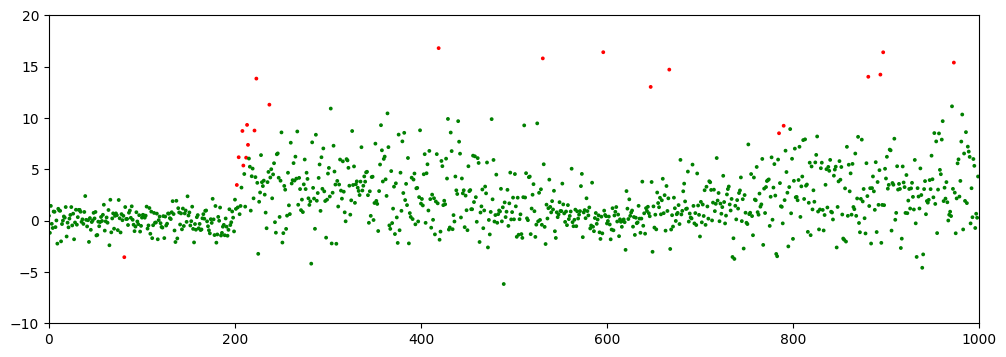

In [42]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 1000)
plt.ylim(-10, 20)
plt.scatter(x=x, y=y, c=c, s=3)

### Cleaning Up Pub/Sub Resources

In [43]:
# deleting input and output subscriptions
subscriber = pubsub_v1.SubscriberClient()
with subscriber:
    try:
        subscription_path = subscriber.subscription_path(PROJECT_ID, INPUT_SUB)
        subscriber.delete_subscription(request={"subscription": subscription_path})
        print(f"Input subscription deleted: {subscription_path}.")
    except NotFound:
        pass

    try:
        subscription_path = subscriber.subscription_path(PROJECT_ID, OUTPUT_SUB)
        subscriber.delete_subscription(request={"subscription": subscription_path})
        print(f"Output subscription deleted: {subscription_path}.")
    except NotFound:
        pass

Input subscription deleted: projects/apache-beam-testing/subscriptions/anomaly-input-9625-sub.
Output subscription deleted: projects/apache-beam-testing/subscriptions/anomaly-output-9625-sub.


In [44]:
# deleting input and output topics
publisher = pubsub_v1.PublisherClient()
with publisher:
    try:
        topic_path = publisher.topic_path(PROJECT_ID, INPUT_TOPIC)
        publisher.delete_topic(request={"topic": topic_path})
        print(f"Input topic deleted: {topic_path}")
    except NotFound:
        pass

    try:
        topic_path = publisher.topic_path(PROJECT_ID, OUTPUT_TOPIC)
        publisher.delete_topic(request={"topic": topic_path})
        print(f"Output topic deleted: {topic_path}")
    except NotFound:
        pass

Input topic deleted: projects/apache-beam-testing/topics/anomaly-input-9625
Output topic deleted: projects/apache-beam-testing/topics/anomaly-output-9625
